In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
# import matplotlib as mpl
# mpl.rcParams['xtick.labelsize'] = 9
# mpl.rcParams['ytick.labelsize'] = 9
# mpl.rcParams['axes.labelsize'] = 9
# mpl.rcParams['figure.figsize'] = (12.0, 4.0)

# import matplotlib.pyplot as plt
# from matplotlib import rc
# from matplotlib import cm
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)

# from matplotlib import rcParams

# rcParams["figure.dpi"] = 150
# rcParams["savefig.dpi"] = 300

orbital_period = 51.4167

In [3]:
plt.style.use('notebook')

In [4]:
def get_spectra(epoch, order, return_header=False):
    spectra = sorted(glob.glob('../data/Spectra/SONG/*.fits'))
    spectrum = spectra[epoch]
    wav, flux, flux_err = [], [], []
    spectra_data = pf.getdata( spectrum ) # Get the data
    spectra_hdr = pf.getheader( spectrum ) # Get the full header
    if return_header:
        return spectra_data[3,order,:], spectra_data[0,order,:] / spectra_data[2,order,:], spectra_hdr
    return spectra_data[3,order,:], spectra_data[0,order,:] / spectra_data[2,order,:]

In [5]:
from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

def interpolate_spectrum(x, y, oversample=5):
    f1  = interpolate.interp1d(x, y, kind = 'cubic')
    df = x[1] - x[0]
    int_wav = np.arange(x[0], x[-1], df / oversample)
    int_flux = f1(int_wav)
    return int_wav, int_flux

def smooth_spectrum(x, y, factor=0.1):
    df = x[1] - x[0]
    return gaussian_filter(y, factor / df)

def flatten_spectrum(x, y, k=3, s=10):
    spl = UnivariateSpline(x, y, k=k, s=s)
    return y / spl(x)

def resolve_spectrum(x, y):
    # Interpolate
    wav, flux = interpolate_spectrum(x,y)
    # Smooth
    flux = smooth_spectrum(wav, flux)
    # Flatten
    flux = flatten_spectrum(wav, flux)
    
    return wav, flux

In [6]:
# %run thuban/setup.py

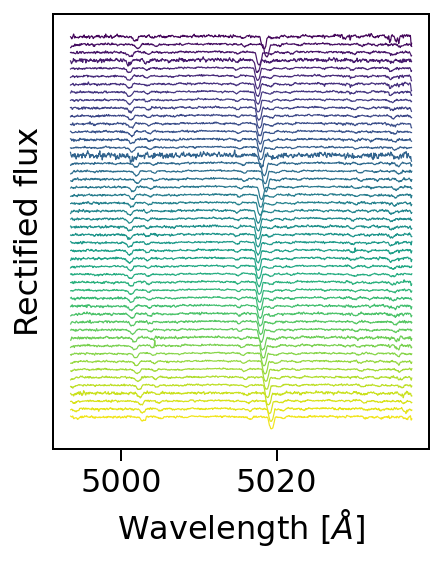

In [7]:
import seaborn as sns
plt.figure(figsize=[3.3648124999999998, 4.])
orders = 16
epochs = 49
colors = np.array(sns.color_palette('viridis', n_colors=epochs))
for order in [18]:
    for epoch, color in zip(range(epochs), colors):
        wav, flux = get_spectra(epoch,order)
        interp_wav, interp_flux = interpolate_spectrum(wav, flux)
        smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.03)
        flat_flux = flatten_spectrum(interp_wav, smooth_flux, s=10)

        plt.plot(interp_wav, flat_flux - epoch * 0.1, linewidth=0.6, c=color, alpha=1.);
    #     plt.xlim(5035, 5070)
#         plt.ylim(-4.1, 0.75)
        plt.xlabel(r'Wavelength [$\AA$]')
        plt.ylabel('Rectified flux')
    plt.yticks([])   
# plt.xlim(4995, 5030)
# plt.ylim(-3.9, 1.)
# plt.savefig('primary.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [8]:
orders = 16
epochs = len(glob.glob('../data/Spectra/SONG/*.fits'))
obs_times = []
for epoch in range(epochs):
    wav, flux, hdr = get_spectra(epoch,order, return_header=True)
    obs_times.append(hdr['BJD-MID'] + 2400000)
#     print(hdr['BJD-MID'])

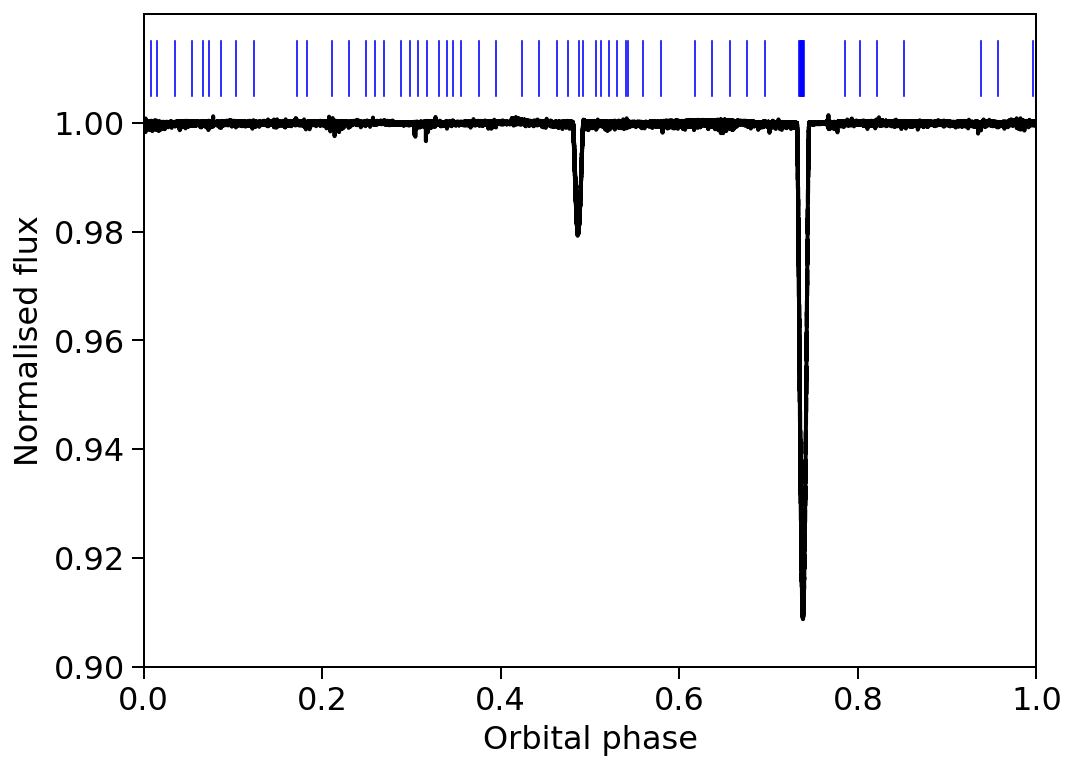

In [9]:
# plt.figure(figsize=[mnras_size(550.11743)[0], 1.8])

t, y, yerr = np.loadtxt('../data/photometry/tess_corrected.txt', usecols=(0,1,2)).T
tjd_0 = 2457000
t += tjd_0

porb = 51.4213
t0 = 1696.0194

fold = t % porb / porb
sort = np.argsort(fold)
plt.plot(fold[sort],y[sort], c='k')

for obs in obs_times:
    plt.plot([(obs % porb / porb), (obs % porb / porb)], [1.015, 1.005], linewidth=0.8, alpha=1., c='blue')

# plt.xlim(1696.0194-0.35, 1696.0194+0.35)
# plt.axvline(1696.0194, c='red')


# for i in range(5):
#     plt.axvline(porb*i + (t0 + tjd_0), c='red')
#     print(porb*i + (t0 + tjd_0))

plt.xlim(0,1)
plt.ylim(0.91, 1.02)
plt.xlabel('Orbital phase')
plt.ylabel('Normalised flux')
plt.yticks(np.array([0.9 , 0.92, 0.94, 0.96, 0.98, 1.]));
# plt.savefig(overleaf_path + 'lc_with_spectra.pdf', dpi=300, bbox_inches='tight', pad_inches=0.)

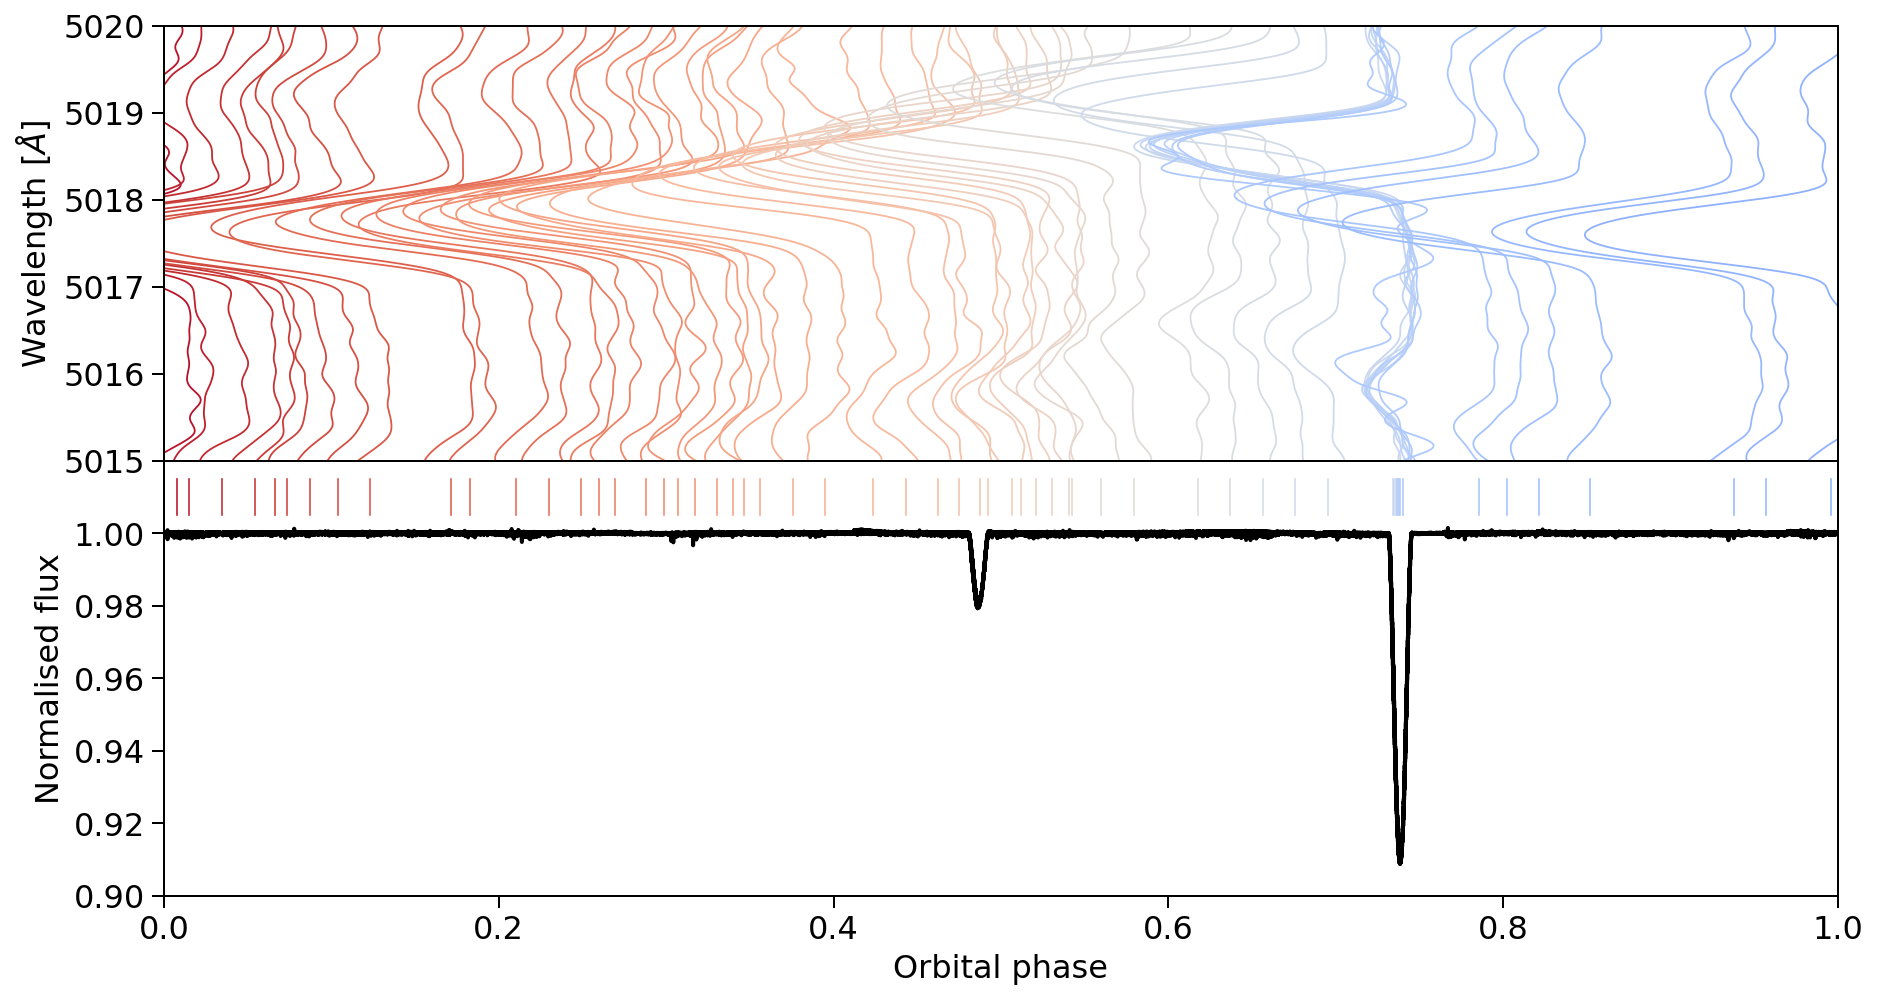

In [10]:
import seaborn as sns

# fig, axes = plt.subplots(2,1, figsize=[mnras_size(550.11743)[0], 4.])
fig, axes = plt.subplots(2,1, figsize=[15,8])
# plt.savefig(overleaf_path + 'spectra.pdf', dpi=300, bbox_inches='tight', pad_inches=0)


ax = axes[1]
t, y, yerr = np.loadtxt('../data/photometry/tess_corrected.txt', usecols=(0,1,2)).T

tjd_0 = 2457000
t += tjd_0

porb = 51.4213
t0 = 1696.0194

fold = t % porb / porb
sort = np.argsort(fold)
ax.plot(fold[sort],y[sort], c='k')

# plt.xlim(1696.0194-0.35, 1696.0194+0.35)
# plt.axvline(1696.0194, c='red')


# for i in range(5):
#     plt.axvline(porb*i + (t0 + tjd_0), c='red')
#     print(porb*i + (t0 + tjd_0))

ax.set_xlim(0,1)
ax.set_ylim(0.91, 1.02)
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalised flux')
ax.set_yticks(np.array([0.9 , 0.92, 0.94, 0.96, 0.98, 1.]));

ax = axes[0]
ax.set_xticks([])

obs_fold = np.array(obs_times) % porb / porb
sort = np.argsort(obs_fold)
colors = np.array(sns.color_palette('coolwarm_r', n_colors=epochs+20))

for obss, color, ss in zip(obs_fold[sort], colors, sort):
    axes[1].plot([obss, obss], [1.015, 1.005], linewidth=0.8, alpha=1., c=color)
#     for order in [18]:
    wav, flux = get_spectra(ss,order)
    interp_wav, interp_flux = interpolate_spectrum(wav, flux)
    smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.1)
    flat_flux = flatten_spectrum(interp_wav, smooth_flux, s=10)

    ax.plot((flat_flux-1) + obss, interp_wav, linewidth=0.9, c=color, alpha=1.);

ax.set_ylabel(r'Wavelength [$\AA$]')
ax.set_xticks([])
ax.set_xlim(0,1)
ax.set_ylim(5015, 5020)

plt.subplots_adjust(hspace=0.)
# plt.savefig('lol.png', dpi=300, bbox_inches='tight', pad_inches=0., transparent=True)

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


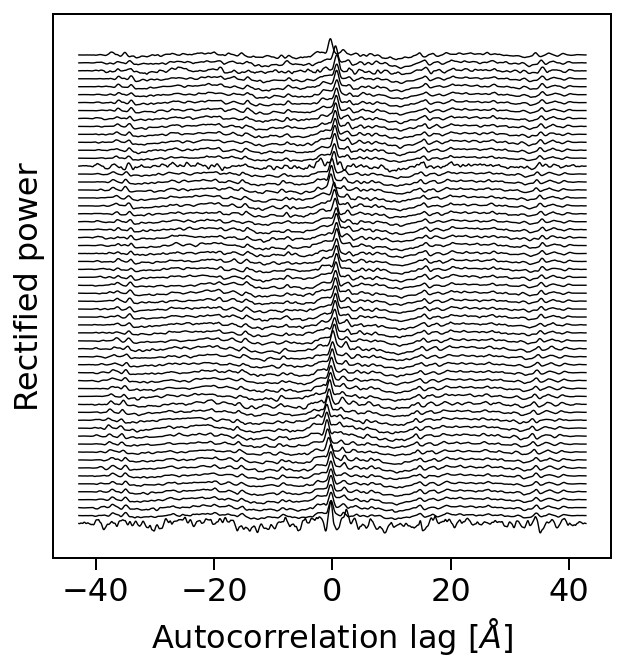

In [11]:
import tqdm

epochs = len(sorted(glob.glob('../data/Spectra/SONG/*.fits')))
smooth_factor = 0.1

order_amps = []
all_times, all_wavs = [], []
fig, ax = plt.subplots(figsize=[5,5])
for order in tqdm.tqdm([15]):
    
    wav, flux, hdr = get_spectra(0,order, return_header=True)
    interp_wav, interp_flux = interpolate_spectrum(wav, flux)
    smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=smooth_factor)
    flat_template = flatten_spectrum(interp_wav, smooth_flux, s=10)

    times = [hdr['BJD-MID']]
    wav_shift = [0.]
    amps = [0]
    
    for epoch in range(1,epochs):
        wav, flux, hdr = get_spectra(epoch,order, return_header=True)
        interp_wav, interp_flux = interpolate_spectrum(wav, flux)
        smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=smooth_factor)
        flat_flux = flatten_spectrum(interp_wav, smooth_flux, s=10)
        acor = np.correlate(flat_template - 1., flat_flux - 1., mode='full')
        df = interp_wav[1] - interp_wav[0]
        lags = df*np.arange(-len(acor)//2, len(acor)//2)
        ax.plot(lags, acor - epoch*0.3, linewidth=0.7, c='black');

        mask = (lags > -10) & (lags < 10)
        max_val = lags[mask][np.argmax(acor[mask])]
        times.append(hdr['BJD-MID'])
        wav_shift.append(max_val)
        amps.append(np.max(acor))
    all_times.append(times)
    all_wavs.append(wav_shift)
    order_amps.append(np.median(amps))
ax.set_xlabel(r'Autocorrelation lag [$\AA$]')
ax.set_ylabel('Rectified power')
ax.set_yticks([])

# ax.set_xlim(-15,15)
# ax.set_xlim(30,60)

# plt.savefig('acor.png', dpi=300, bbox_inches='tight')

all_times, all_wavs = np.array(all_times), np.array(all_wavs)

In [12]:
from scipy.optimize import minimize

def model(theta, x):
    a, c, d, x0 = theta
    gaussian = a*np.exp(-(x-x0)**2/(2*d**2)) + 0#c
    return gaussian

def func(theta, x, y):
    gaussian = model(theta, x)
    return 0.5*np.sum((y-gaussian)**2)#/sigma2 + np.log(sigma2))

def fit_gaussian(x, y, x0):
    res = minimize(func, x0, args=(x, y))
    return res

In [13]:
# line_list = np.loadtxt('/Users/danielhey/iSpec/input/linelists/CCF/HARPS_SOPHIE.A0.350_1095nm/mask.lst', skiprows=1)

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return array[idx]

# # find_nearest(line_list[:,0]*10, 5316)

100%|██████████| 61/61 [00:18<00:00,  3.24it/s]


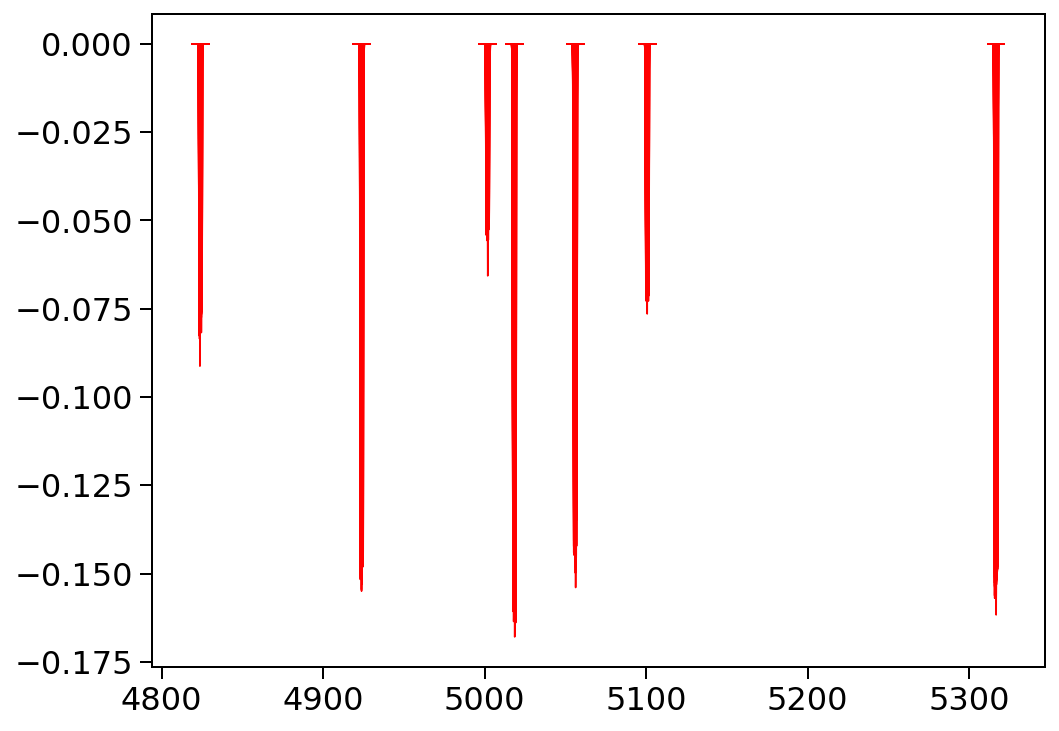

In [14]:
import tqdm
times = []
fwhms = []
wav_shifts = []
bvcs = []
    
lines = np.array([4824.13, 4923.93, 
                  #4957.3,
                  5018.44, 5001.86, 5056.32, 5100.66, 5316.61])
for epoch in tqdm.tqdm(range(epochs)):
    # FOR EVERY EPOCH
    wav, flux, hdr = get_spectra(epoch, 5, return_header=True)
    times.append(hdr['BJD-MID'])
    bvcs.append(hdr['BVC'])
    flat_waves = []
    flat_fluxes = []
    for order in [9,10,11,12,13,15,16,17,18,19, 20,21,22,23,24,25]:
        fwhm = []
        wav_shift = []
        # AND FOR EVERY ORDER.. 
        wav, flux, hdr = get_spectra(epoch, order, return_header=True)
        interp_wav, interp_flux = interpolate_spectrum(wav, flux)
        smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.05)
        
        flat_waves.extend(interp_wav)
        flat_fluxes.extend(flatten_spectrum(interp_wav, smooth_flux, s=10, k=5))
        
    flat_waves, flat_fluxes = np.array(flat_waves), np.array(flat_fluxes)
    fwhm = []
    wav_shift = []
    sigma = []
    for line in lines:
        # Fit each line profile
        x0 = [-0.15,0,1,line]
        mask = (flat_waves > (line - 5)) & (flat_waves < (line + 5))
        res = fit_gaussian(flat_waves[mask], (flat_fluxes - 1.)[mask], x0)
        plt.plot(flat_waves[mask], model(res['x'], flat_waves[mask]), c='red', linewidth=0.8)
        
        fwhm.extend([res.x[-2]])
#         sigma.extend([res.x[-2]])
        wav_shift.extend([res.x[-1]])
    fwhms.append(fwhm)
    wav_shifts.append(wav_shift)
#     plt.plot(flat_waves, flat_fluxes)
fwhms, wav_shifts = np.array(fwhms), np.array(wav_shifts)
#         fwhms.append(fwhm)
#         wav_shifts.append(wav_shift)

In [31]:
np.median((wav_shifts  - lines[None,:]) + np.array(bvcs)[:,None] / 299792.458, axis=1)

array([-0.0915913 ,  0.26033681, -0.70038709, -0.89535691, -0.86997843,
       -0.87075477, -0.85851908, -0.85506095, -0.80112998, -0.70679285,
       -0.64066379, -0.60620508, -0.55608518, -0.5216322 , -0.47436319,
       -0.41779333, -0.03116966,  0.07333483,  0.18058427, -0.38657061,
       -0.47358922, -0.5508825 , -0.79386422, -0.80052326, -0.81174071,
       -0.82330738, -0.81752276, -0.82187656, -0.80853981, -0.73807956,
       -0.68639732, -0.65227823, -0.62923706, -0.59946752, -0.56398003,
       -0.51981331, -0.475165  , -0.43736705, -0.20198661, -0.14237736,
       -0.05088621,  0.06847369,  0.17048314,  0.25504151,  0.37591421,
        0.50627663,  0.6457693 ,  0.84853629,  0.89659543,  0.84427746,
        0.71600074,  0.5307709 ,  0.16787024,  0.1628877 ,  0.15926703,
        0.1508248 ,  0.15159962,  0.14430931,  0.12417133,  0.12228407,
        0.07482456])

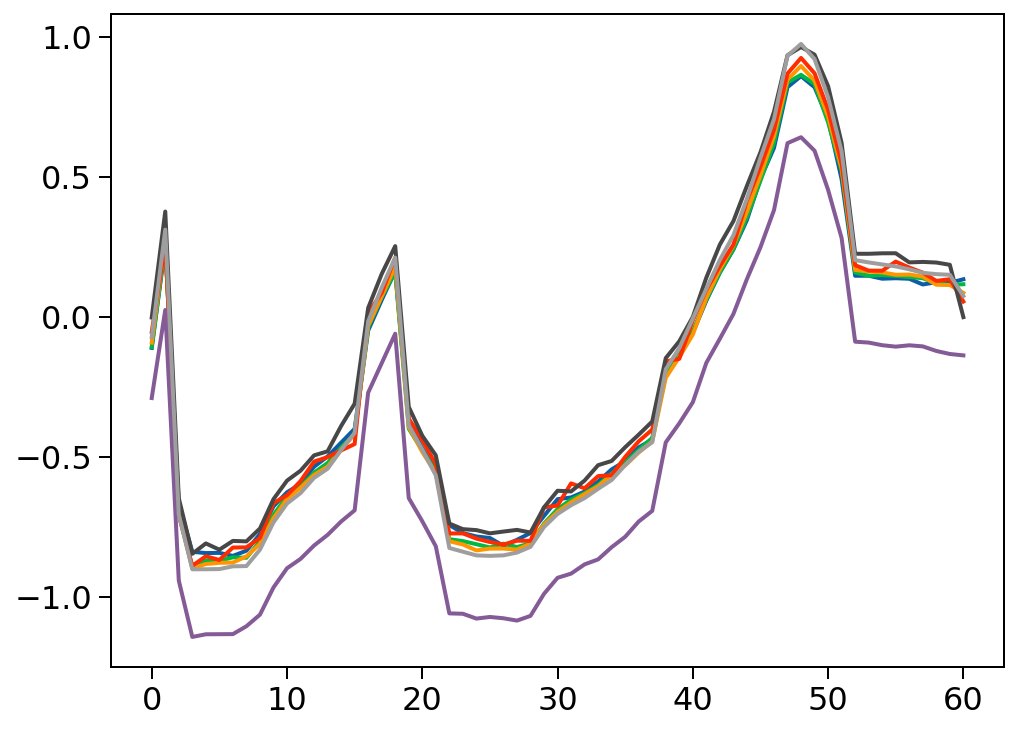

In [32]:
plt.plot((wav_shifts  - lines[None,:]) + np.array(bvcs)[:,None] / 299792.458);

In [33]:
RV = 299792.458 * ((wav_shifts - lines[None,:]) / lines[None,:]) + np.array(bvcs)[:,None]
RV_err = RV * (fwhms / wav_shifts)
total = RV#RV - np.median(RV, axis=0)

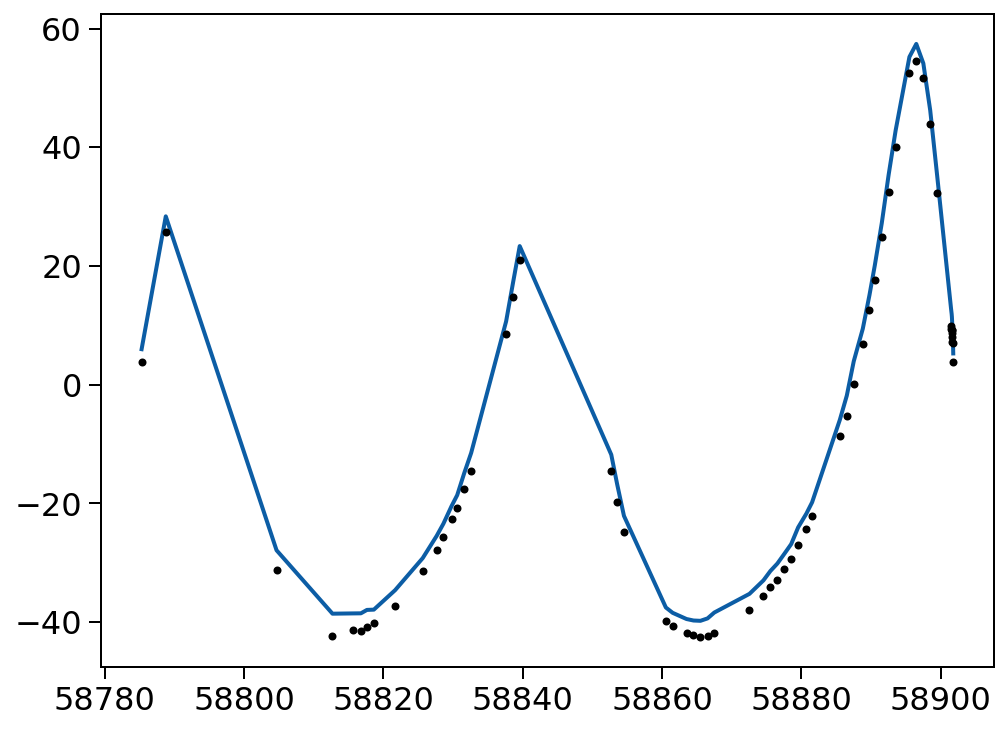

In [56]:
plt.plot(times, RV[:,6]);
plt.plot(times, np.mean(RV, axis=1), '.k')

In [60]:
RV_err = np.std(total, axis=1)

Text(0, 0.5, 'RV [km/s]')

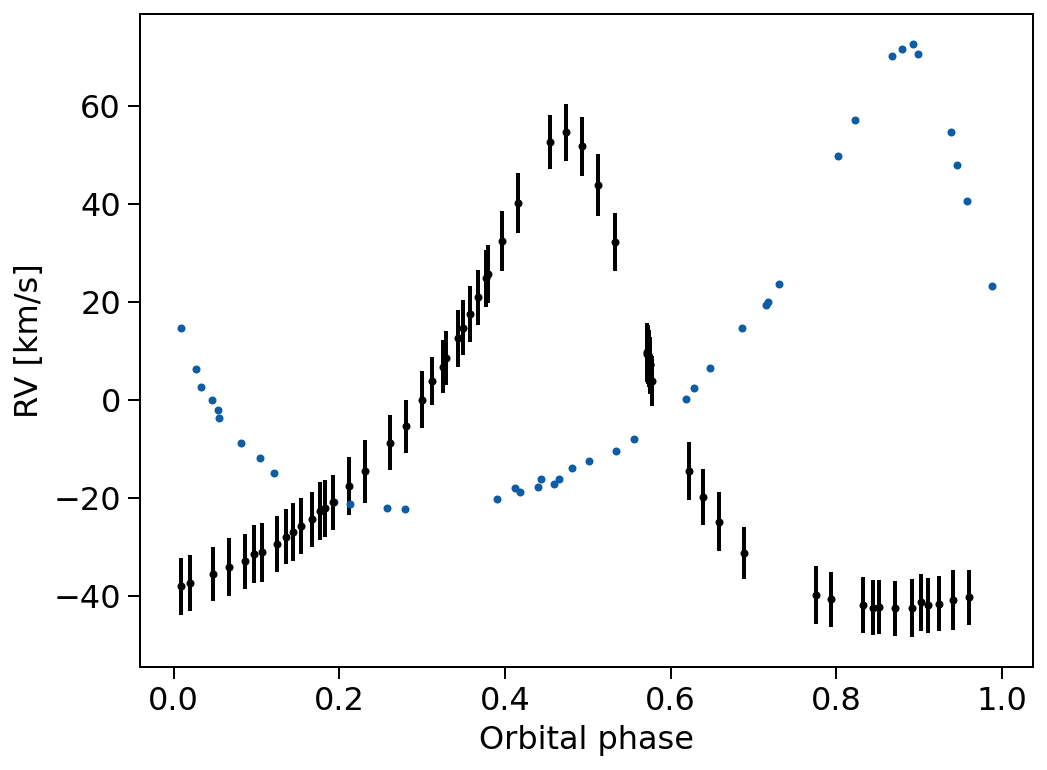

In [61]:
plt.errorbar((np.array(times)) % orbital_period / orbital_period, np.mean(total, axis=1), fmt='.k', yerr=RV_err)
rv_time, rv_rv, rv_err = np.loadtxt('../data/RV/bischoff_rv_fixed_time.txt', usecols=(0,1,2)).T
plt.plot(rv_time % orbital_period / orbital_period, rv_rv - np.median(rv_rv), '.')
plt.xlabel('Orbital phase')
plt.ylabel('RV [km/s]')
# plt.savefig('soda.png', dpi=300, bbox_inches='tight')

In [31]:
np.savetxt('soda_rv2.txt', list(zip(times, np.mean(total, axis=1), RV_err)))

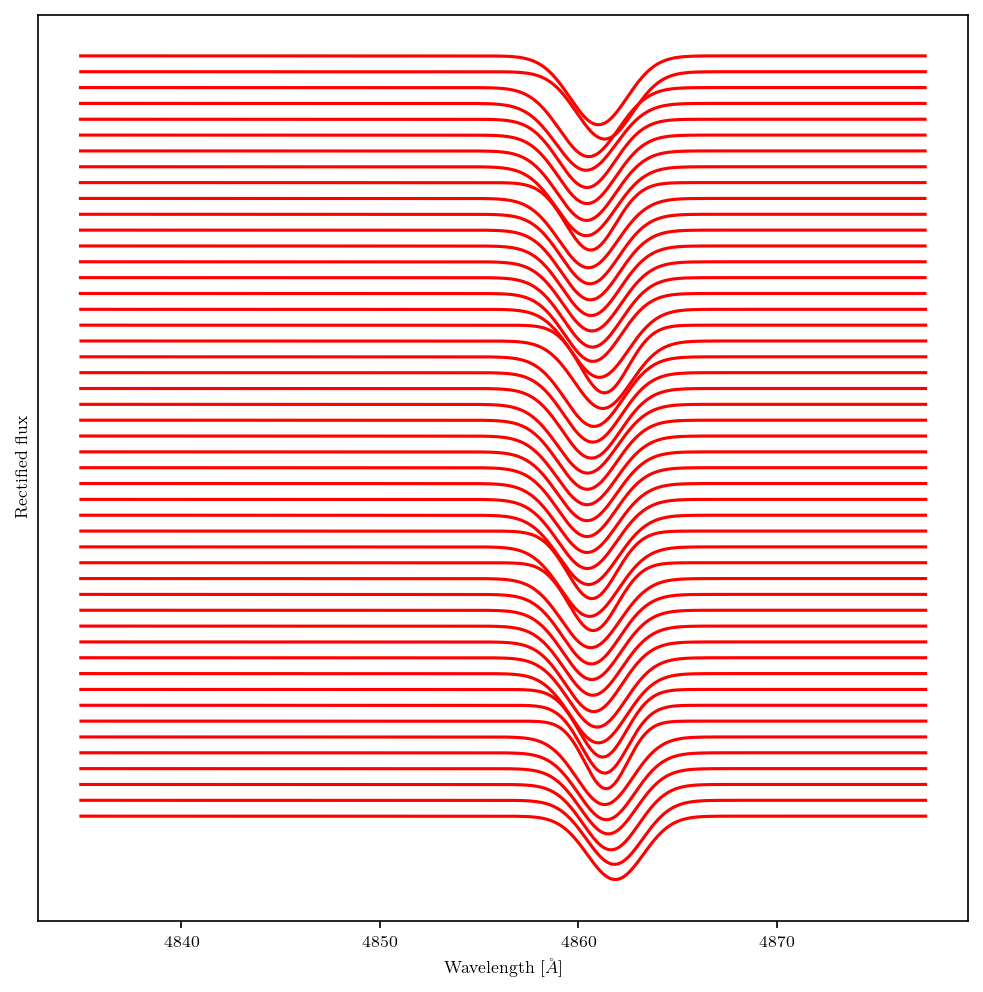

In [30]:
import seaborn as sns
plt.figure(figsize=[8,8])
epochs = 49
colors = np.array(sns.color_palette('plasma', n_colors=epochs))
times, wav_shifts = [], []
for order in [14]:
    for epoch, color in zip(range(epochs), colors):
        wav, flux, hdr = get_spectra(epoch,order, return_header=True)
        interp_wav, interp_flux = interpolate_spectrum(wav, flux)
        smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.03)
        flat_flux = flatten_spectrum(interp_wav, smooth_flux, s=10)
        times.append(hdr['BJD-MID'])
        
        x0 = [-0.15,0,1,4860]
        res = fit_gaussian(interp_wav, flat_flux - 1., x0)
        wav_shifts.append(res['x'][-1])
#         plt.plot(interp_wav, flat_flux - epoch * 0.1, linewidth=0.5, c='black', alpha=1.);
        plt.plot(interp_wav, model(res['x'], interp_wav) - epoch * 0.1, c='red')
        
        plt.xlabel(r'Wavelength [$\AA$]')
        plt.ylabel('Rectified flux')
    plt.yticks([])

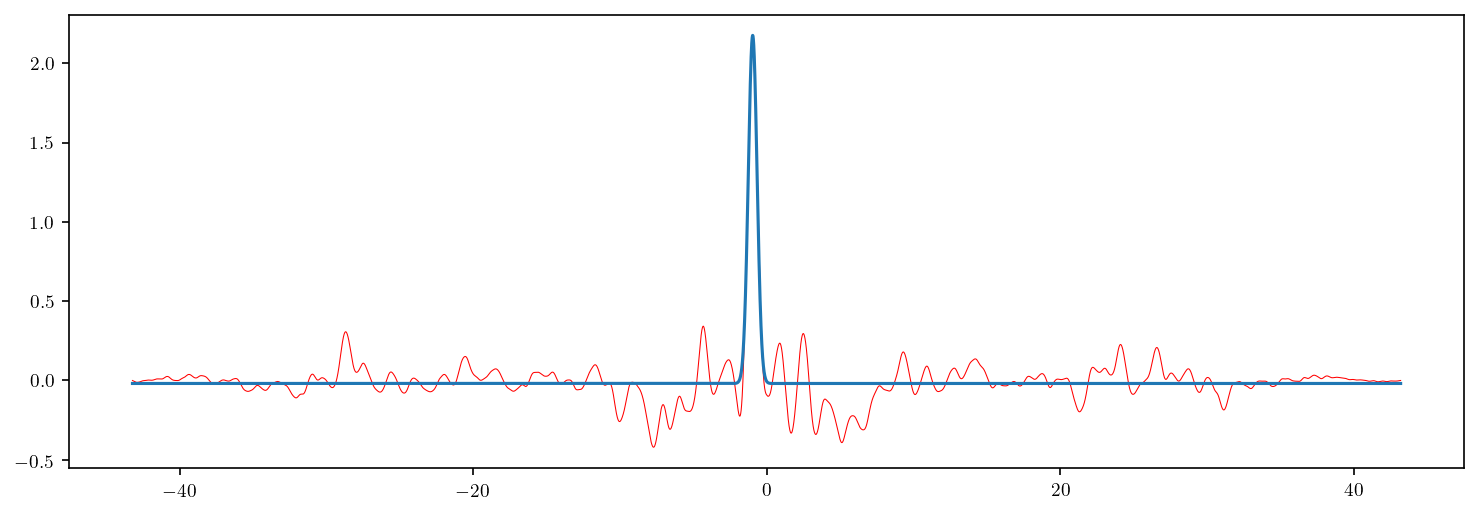

In [172]:
from scipy.optimize import minimize

def model(theta, x):
    a, c, d, x0 = theta
    gaussian = a*np.exp(-(x-x0)**2/(2*d**2)) + c
    return gaussian

def func(theta, x, y):
    gaussian = model(theta, x)
    return 0.5*np.sum((y-gaussian)**2)#/sigma2 + np.log(sigma2))

p = [1,0,1,1]
res = minimize(func, p, args=(lags, acor))

plt.plot(lags, acor, 'r', linewidth=0.5)
plt.plot(lags, model(res['x'], lags))

In [150]:
popt

array([ 2.09410223,  1.        , -0.02447767,  0.37979964, -0.87527451])

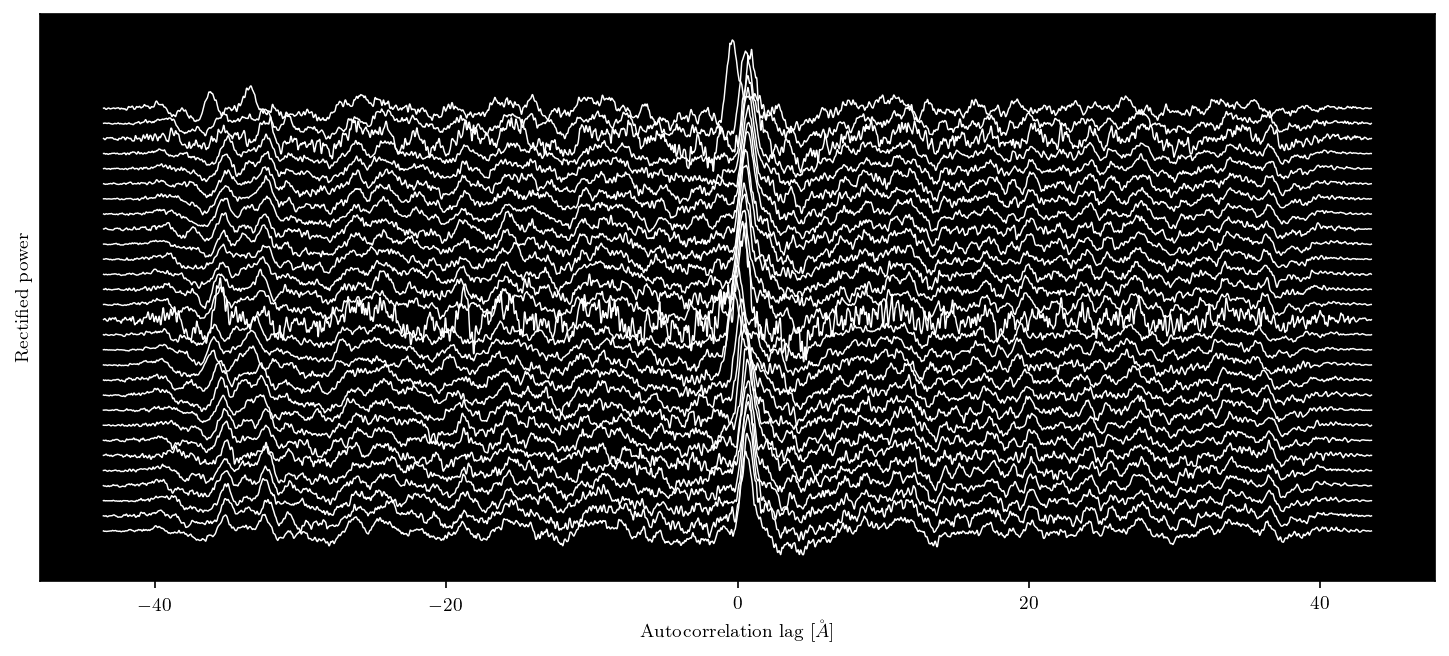

In [17]:
order = 17
epochs = 30

wav, flux = get_spectra(0,order)
interp_wav, interp_flux = interpolate_spectrum(wav, flux)
smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.03)
flat_template = flatten_spectrum(interp_wav, smooth_flux, s=10)
# plt.plot(interp_wav, flat_template, c='red')

fig, ax = plt.subplots(figsize=[12,5])


for epoch in range(1,epochs):
    wav, flux = get_spectra(epoch,order)
    interp_wav, interp_flux = interpolate_spectrum(wav, flux)
    smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.03)
    flat_flux = flatten_spectrum(interp_wav, smooth_flux, s=10)
    acor = np.correlate(flat_template - 1., flat_flux - 1., mode='full')
#     acor = acor[acor.size // 2:]
    df = interp_wav[1] - interp_wav[0]
    lags = df*np.arange(-len(acor)//2, len(acor)//2)
    ax.plot(lags, acor - epoch*0.1, linewidth=0.7, c='white');
    
ax.set_xlabel(r'Autocorrelation lag [$\AA$]')
ax.set_ylabel('Rectified power')
ax.set_yticks([])

# ax.set_xlim(-5,5)
ax.set_facecolor('black')
# ax.set_xlim(30,60)

# plt.savefig('acor.png', dpi=300, bbox_inches='tight')

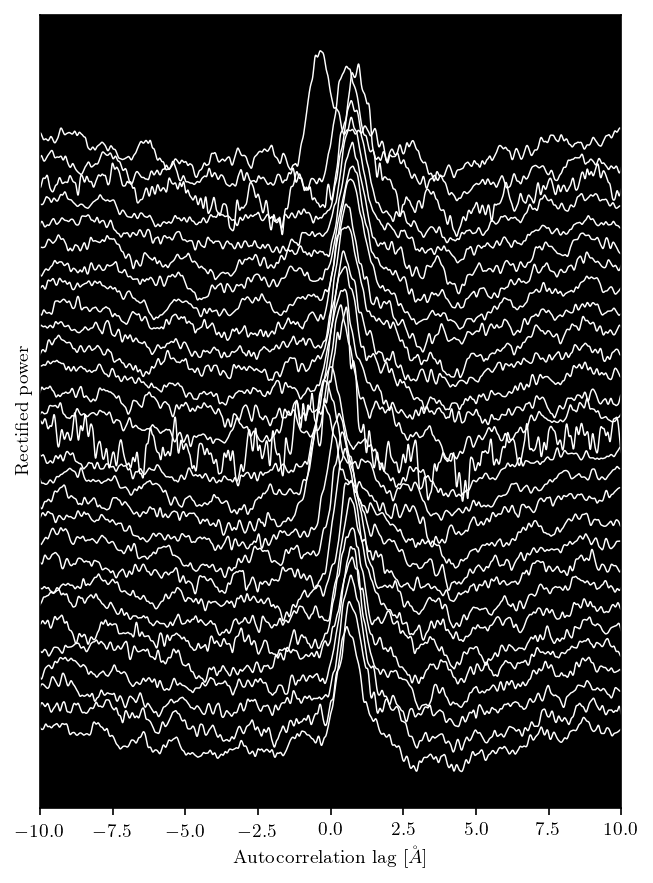

In [23]:
order = 17
epochs = 30

wav, flux = get_spectra(0,order)
interp_wav, interp_flux = interpolate_spectrum(wav, flux)
smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.03)
flat_template = flatten_spectrum(interp_wav, smooth_flux, s=10)
# plt.plot(interp_wav, flat_template, c='red')

fig, ax = plt.subplots(figsize=[5,7])


for epoch in range(1,epochs):
    wav, flux = get_spectra(epoch,order)
    interp_wav, interp_flux = interpolate_spectrum(wav, flux)
    smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.03)
    flat_flux = flatten_spectrum(interp_wav, smooth_flux, s=10)
    acor = np.correlate(flat_template - 1., flat_flux - 1., mode='full')
#     acor = acor[acor.size // 2:]
    df = interp_wav[1] - interp_wav[0]
    lags = df*np.arange(-len(acor)//2, len(acor)//2)
    ax.plot(lags, acor - epoch*0.1, linewidth=0.7, c='white');
    
ax.set_xlabel(r'Autocorrelation lag [$\AA$]')
ax.set_ylabel('Rectified power')
ax.set_yticks([])

ax.set_xlim(-10,10)
ax.set_facecolor('black')
# ax.set_xlim(30,60)

plt.savefig('acor.png', dpi=300, bbox_inches='tight')